In [ ]:
import os
import math
import pandas as pd
import numpy as np
import requests
from requests.auth import HTTPBasicAuth

In [ ]:
def make_list(WJ_list = 'wj_list', p_list = pd.DataFrame()):
    path = os.getcwd()
    f2 = os.path.join(path, "data", WJ_list + '.xlsx')
    List = pd.read_excel(open(f2, 'rb'), header=0)
    List = List.merge(p_list, left_on=['name', 'parent'], right_on=['childName',  'parentName'] , how = 'outer')
    List.to_excel(WJ_list + '.xlsx', sheet_name = 'data')

def data_merge(WJ_list = 'wj_list', raw_file = 'output', merge = 'merge'):
    """
        작성자: sjyoo
        작성일: 190612
        기능: list와 raw 파일 AVG, RT 등을 merge
        입력: 데이터 table <- 지금은 excel file
        출력: C:/Users/OBELAB_JH_DESKTOP/Documents/GitHub/testfornothing/OBE/data/ ~~ xlsx파일
        용례: data_merge(리스트, 로우 데이타, 멀지 아웃풋)
        배고프네...
    """
    Task = {}
    task_list = ['REST', 'CBTTF', 'CBTTB', 'GNG', 'TWOBACK', 'STRC', 'STRI', 'REPEAT', 'MIND', 'FOLD']
    print('merge 시작')
    # file = os.path.join(path, "data", 'sj_perforamance.xls')
    path = os.getcwd()
    f1 = os.path.join(path, "data", raw_file + '.xlsx')
#     f2 = os.path.join(path, "data", WJ_list + '.xlsx')
    f2 = os.path.join(path, WJ_list + '.xlsx')

    List1 = pd.read_excel(open(f2, 'rb'), header=0)
    

    for i in range(len(task_list)):
        Task[task_list[i]] = pd.read_excel(open(f1, 'rb'), sheet_name = '%s' % task_list[i], header=None).T.dropna(how = 'all')
        Task[task_list[i]] = pd.DataFrame.from_dict(Task[task_list[i]])
        Task[task_list[i]] = Task[task_list[i]].replace(['TASKMARKER','OUTTOUCH', 'TASKMARKER\r','OUTTOUCH\r'],['', '', '', '']).dropna(axis = 1, how = 'all')
        Task[task_list[i]] = Task[task_list[i]].fillna('damm')
        


    for task in task_list:
#         print(Task[task])
        print(task)
        pack = pd.DataFrame(Task[task][0])
        idx = Task[task].index
        # print(idx)
        # print(col)
        col = Task[task].columns
        
        if 'GNG' in task or 'TWOBACK' in task or 'STRC' in task or 'STRI' in task:
            Cor_list = []
            RT = []
            Acc =[]
#             print(Task[task])
            for i in idx:
                Cor = 0
                LV = 0
                RT_list = []
                for j in col:
                    if Task[task][j][i][:2] == 'LV':
                        marker = Task[task][j][i].split('/')
                        if 'LV' in marker[0]:
                            Cor += int(marker[1])
                            LV += 1
                            if '1-1' in marker[2]:
                                if int(marker[3]) < 2000 :
                                    RTint = int(marker[3])
                                    RT_list.append(RTint)
                        else:
                            continue
                    else:
                        pass
                 
                Cor_list.append(Cor)
                if len(RT_list) is not 0:
                    RT.append(sum(RT_list) / len(RT_list))
                else:
                    RT.append(0)
                
                if LV == 0:
                    Acc.append(0)
                else:
                    Acc.append(Cor/LV)
                
            pack['%s_Cor' % task] = Cor_list
            pack['%s_RT' % task] = RT
            pack['%s_ACC' % task] = Acc
            print('정답률, 반응시간')
            print('과제 완료')
            
            
        elif 'CBTTF' in task or 'CBTTB' in task or 'MIND' in task or 'REPEAT' in task or 'FOLD' in task:
            Cor_list = []
            Acc =[]
            for i in idx:
                Cor = 0
                LV = 0
                for j in col:
                    if Task[task][j][i][:2] == 'LV':
                        marker = Task[task][j][i].split('/')
                        if 'LV' in marker[0]:
                            Cor += int(marker[1])
                            LV += 1
                        else:
                            continue
                    else:
                        pass

                Cor_list.append(Cor)
                if LV == 0:
                    Acc.append(0)
                else:
                    Acc.append(Cor/LV)
            
            pack['%s_Cor' % task] = Cor_list
            pack['%s_ACC' % task] = Acc
            print('정답률')
            print('과제 완료')
            
        else:
            print('과제 pass')
            pass
        List1 = List1.merge(pack, left_on='taskUUID', right_on=0 , how = 'outer')

    List1.pop('0_x')
    List1.pop('0_y')
    List1.to_excel(merge + '.xlsx', sheet_name = 'data')
    print('완료')
    return
    
def raw_to_LVAn(raw):
    marker = raw[raw].split('/')
    print(marker)
    # level_anlaysis = raw.pivot(columns = 'childName', values = 'raw')
    return




    return

def request_to_table(url, uuid, my_id, my_pw):
    """
        작성자: cmlee
        수정자: sjyoo
        
        
        작성일: 190509
        수정일: 190611 
        기능: 요청 정보를 이용해서 서버에서 데이터 테이블 형태로 반환
        입력: url, id, pw, taskuuid
        출력: pandas DataFrame : header + contents
        용례: raw = request_to_table(str(api_url), str(uuid)/ list(uuid), str(my_id), str(my_pw))
    """
    raw = pd.DataFrame()
    print('table 요청 시작')
    for child in uuid:
#         print(child)
        url_uuid = url + '?taskUUID=' + child
        r = requests.get(url=url_uuid, auth=HTTPBasicAuth(my_id, my_pw))
        r = r.content.decode("utf-8")
        r = r.split('\n')
        t_head = r.pop(0).split(',')
        t_head[-1] = t_head[-1][0:-1]
        t_body = [t.split(',') for t in r if t != '']
        data = pd.DataFrame(t_body, columns=t_head)
        data = data[data.taskUUID != '']
        mx = data.taskSubID.max()
        if mx != '':
            data = data.query('taskSubID == "'+str(mx)+'"')
        raw = pd.concat([data, raw], axis=0)
#         print('%s 완료' % child)
    print("raw export 완료")
    return raw

def access_to_table(connect_info, uuid, table = 'uuid'):
    """
        작성자: sjyoo
        작성일: 190611
        기능: table 접속
        입력: connect_info: id, pw; uuid = taskuuid; table = 받고 싶은 데이터 table
        출력: pandas DataFrame : 현재는 performance 
        용례: raw = access_to_table(connect_info, uuid, table = 'uuid'&'raw'&'perf')
    """
    # base_url = 'http://ec2-15-164-48-95.ap-northeast-2.compute.amazonaws.com'
    base_url = 'http://obelab-api.com'
    api_uuid = base_url + '/api/analysis/taskuuid/'
    api_raw = base_url + '/api/analysis/metaraw/'
    api_perf = base_url + '/api/analysis/metamarker/'
    print('table access 시작')
    if table == 'uuid':
        return request_to_table(api_uuid, uuid, connect_info[0], connect_info[1])
    elif table == 'raw':
        return request_to_table(api_raw, uuid, connect_info[0], connect_info[1])
    elif table == 'perf':
        return request_to_table(api_perf, uuid, connect_info[0], connect_info[1])
    print("raw 완료")


def get_UUID(connect_info, date1 = '2000-01-01', date2 = '2030-01-01'):
    """
        작성자: sjyoo
        작성일: 190612
        기능: date로 아이디 뽑아내기. UUID 뽑을 거임.
        입력: 접속 정보, 시작일, 종료일
        출력: uuid 리스트
        용례: get_UUID(접속정보, 시작일, 종료일)
    """
    base_url = 'http://obelab-api.com'
    api_uuid = base_url + '/api/analysis/taskuuid/'

    uuid = pd.DataFrame()
    #지금은 다 불러와서 date로 filtering
    r = requests.get(url=api_uuid, auth=HTTPBasicAuth(connect_info[0], connect_info[1]))
    r = r.content.decode("utf-8")
    r = r.split('\n')
    t_head = r.pop(0).split(',')
    t_head[-1] = t_head[-1][0:-1]
    t_body = [t.split(',') for t in r]
    data = pd.DataFrame(t_body, columns=t_head)
    return data.query('taskCreated >= "' + date1 + '" and taskCreated <= "' + date2 +'"')

def server_connect_info():
    my_id = 'admin'
    my_pw = 'obe1234'

    return my_id, my_pw

In [ ]:
connect_info = server_connect_info()
p_list = get_UUID(connect_info, '2019-06-21', '2019-06-24')
target_child = p_list.taskUUID
print(target_child)

In [ ]:
raw = access_to_table(connect_info = connect_info, uuid=target_child, table = 'perf') #한예준

In [ ]:
raw_to_data(raw, 'taskUUID')

In [ ]:
make_list('wj_list', p_list)

In [ ]:
data_merge('wj_list', 'taskUUID', 'Result_0624_1')

In [23]:
import os
import sys
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt

path = os.getcwd()
f = os.path.join(path, "data", 'Result_0624_1.xlsx')
List = pd.read_excel(open(f, 'rb'), sheet_name = 'data4', header=0, index_col = 0)


# List[List.dtypes[(List.dtypes=="float64")|(List.dtypes=="int64")]
#                         .index.values].hist(figsize=[15,15])

print(List.columns)
List = List.loc[(List.date == '6월 23일') | (List.date == '6월 22일')]
List['GNG_z'] = List['GNG_ACC'] / List['GNG_RT']*1000
List['STRC_z'] =  List['STRI_ACC'] / List['STRI_RT']*1000
List['STRI_z'] =  List['STRC_ACC'] / List['STRC_RT']*1000
List['STRE_z'] =  List['STRI_z'] - List['STRC_z']

np.percentile(List['STRE_z'], 50)
print(List['REPEAT_ACC'])

Index(['ID', 'num', 'date', 'time', 'Sex', 'grade', 'name', 'CBTTF_Cor',
       'CBTTF_ACC', 'CBTTB_Cor', 'CBTTB_ACC', 'GNG_Cor', 'GNG_RT', 'GNG_ACC',
       'TWOBACK_Cor', 'TWOBACK_RT', 'TWOBACK_ACC', 'STRC_Cor', 'STRC_RT',
       'STRC_ACC', 'STRI_Cor', 'STRI_RT', 'STRI_ACC', 'Stroop effect',
       'REPEAT_Cor', 'REPEAT_ACC', 'MIND_Cor', 'MIND_ACC', 'FOLD_Cor',
       'FOLD_ACC'],
      dtype='object')
143    0.583333
144    0.416667
145    0.166667
146    0.083333
147    0.000000
148    0.083333
149    0.583333
150    0.166667
151    0.333333
152    0.083333
153    0.250000
154    0.083333
155    0.750000
156    0.250000
157    0.083333
158    0.250000
159    0.250000
160    0.416667
74     0.750000
161    0.916667
163    0.166667
164    0.083333
165    0.166667
166    0.833333
167    0.416667
168    0.416667
169    0.833333
170    0.500000
171    0.083333
172    0.083333
         ...   
107    0.666667
85     0.083333
192    0.166667
193    0.250000
194    0.166667
195    0.166667

In [33]:
# print(List.CBTTF_ACC)
# plt.hist(List.CBTTF_ACC)

ID
pass
num
pass
date
pass
time
pass
Sex
pass
grade


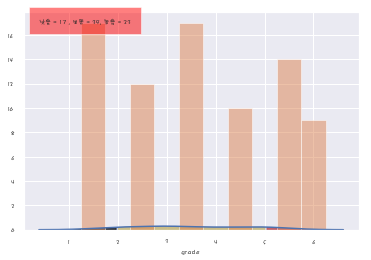

name
pass
CBTTF_Cor
pass
CBTTF_ACC


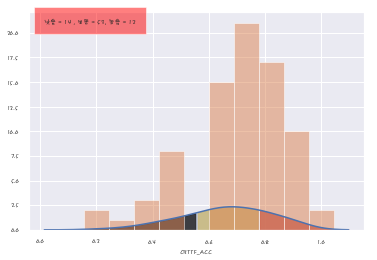

CBTTB_Cor
pass
CBTTB_ACC


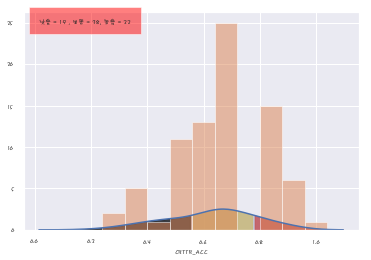

GNG_Cor
pass
GNG_RT


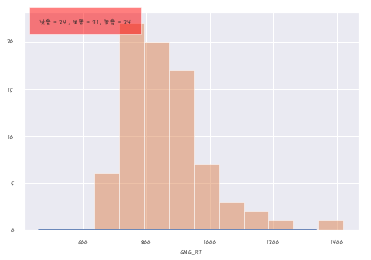

GNG_ACC


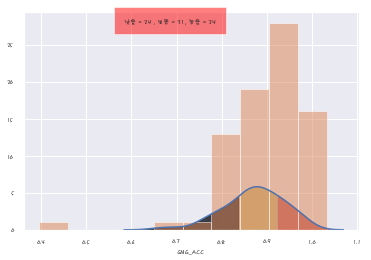

TWOBACK_Cor
pass
TWOBACK_RT


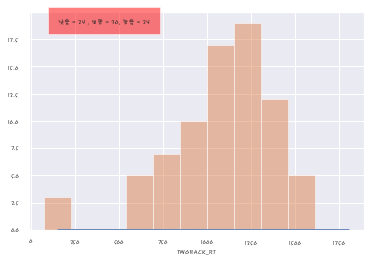

TWOBACK_ACC


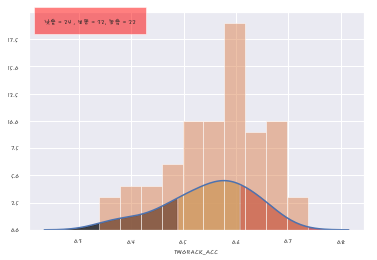

STRC_Cor
pass
STRC_RT


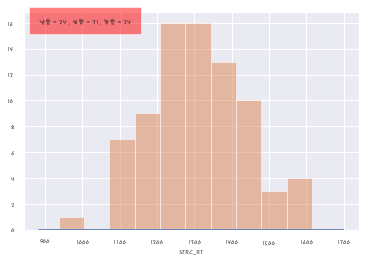

STRC_ACC


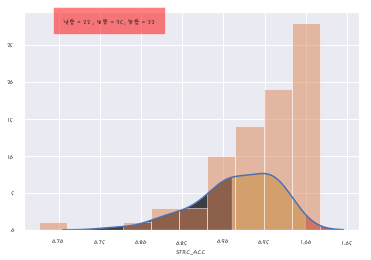

STRI_Cor
pass
STRI_RT


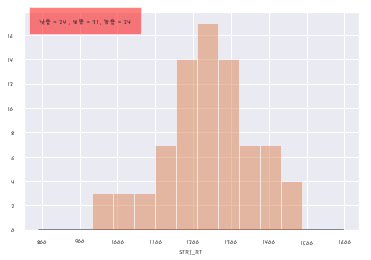

STRI_ACC


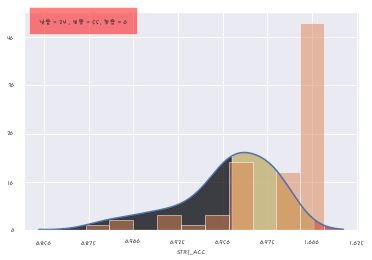

Stroop effect


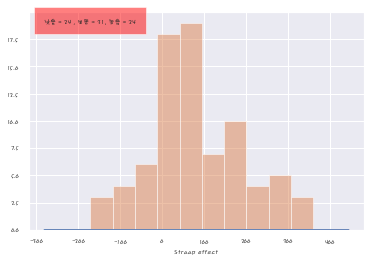

REPEAT_Cor
pass
REPEAT_ACC


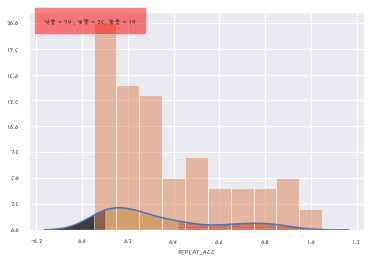

MIND_Cor
pass
MIND_ACC


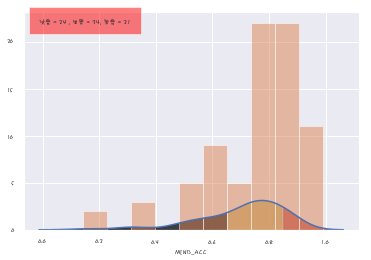

FOLD_Cor
pass
FOLD_ACC


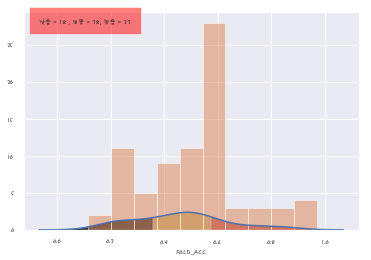

GNG_z


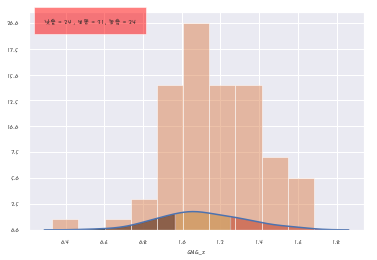

STRC_z


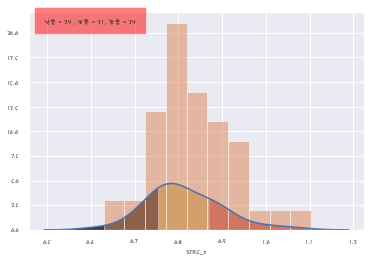

STRI_z


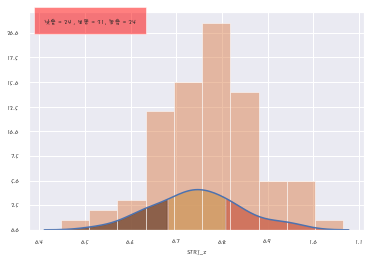

STRE_z


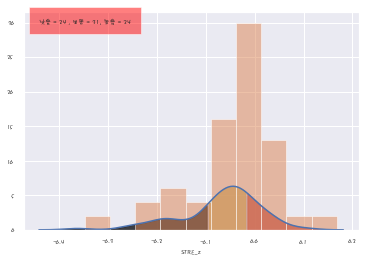

In [64]:
import scipy.stats as st
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


sns.set(font_scale=0.5)
mpl.rcParams['axes.unicode_minus'] = False
path = 'C:/Windows/Fonts/HYSNRL.ttf'
font_name = fm.FontProperties(fname=path).get_name()
plt.rc('font', family=font_name)

for feature in List:
    print(feature)
    if 'ID' in feature or 'num' in feature or 'date' in feature or 'time' in feature or 'Sex' in feature or 'name' in feature or 'Cor' in feature: 
        print('pass')
        pass
    else:
        a = List[feature].dropna()
        low = a[a < np.percentile(a, 30)].count()
        high = a[a > np.percentile(a, 70)].count()
        middle = a[(a <= np.percentile(a, 70))&(a >= np.percentile(a, 30))].count()
        
        points = sns.distplot(a.dropna() 
#                               , bins = 1000
#                               , fit=sp.stats.norm
                              , hist =False, kde = True, kde_kws = {'shade' :True, 'kernel' : 'gau'
#                                                                  , 'bw' : 0.1
                                                                    , 'clip' :(a.min(),a.max()) 
                                                                }
                             ).get_lines()[0].get_data()
        
        x = points[0]
        y = points[1]
#         th = sms.DescrStatsW(a).tconfint_mean(0.0001)[0]
#         se = sms.DescrStatsW(a).tconfint_mean(0.0001)[1]
        plt.fill_between(x,y, where = x > np.percentile(a, 75), color='r', alpha=0.8, label = '높음')
        plt.fill_between(x,y, where = x <  np.percentile(a, 25), color='k', alpha=0.8, label = '낮음')
        plt.fill_between(x,y, where = (x <=  np.percentile(a, 75)) & (x >= np.percentile(a, 25)), color='y', alpha=0.8, label = '보통')
        hito = plt.hist(a, alpha = 0.5, align  = 'right' )
#         plt.text(.50, .5, '낮음 = %s , 중간 = %s , 보통 = %s' % (low, middle, high), horizontalalignment='center',
#      verticalalignment='center',
#      textcoords = 'axes fraction')
        plt.text(x.min(), hito[0].max(), '낮음 = %s , 보통 = %s, 높음 = %s' % (low, middle, high), style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
#         plt.annotate('낮음 = %s' % low, xy = (np.percentile(a, 25),np.percentile(a, 25)), xytext=(0.25, 0.5), textcoords = 'axes fraction', arrowprops = dict(color = 'g', alpha= 0.5))
#         plt.annotate('중간 = %s' % middle, xy = (np.percentile(a, 50),np.percentile(a, 50)), xytext=(0.5, 0.7), textcoords = 'axes fraction', arrowprops = dict(color = 'g', alpha= 0.5))
#         plt.annotate('높음 = %s' % high, xy = (np.percentile(a, 75),np.percentile(a, 75)), xytext=(0.75, 0.5), textcoords = 'axes fraction', arrowprops = dict(color = 'g', alpha= 0.5))

        plt.savefig(feature + 'xline10.png', format = 'png', dpi = 1200)
        plt.show()

ID
pass
num
pass
date
pass
time
pass
Sex
pass
grade


TypeError: unsupported operand type(s) for *: 'builtin_function_or_method' and 'float'

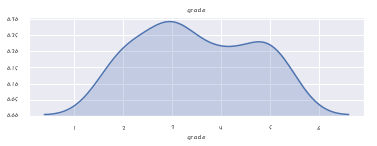

In [44]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


sns.set(font_scale=0.5)
mpl.rcParams['axes.unicode_minus'] = False
path = 'C:/Windows/Fonts/HYSNRL.ttf'
font_name = fm.FontProperties(fname=path).get_name()
plt.rc('font', family=font_name)

for feature in List:
    print(feature)
    if 'ID' in feature or 'num' in feature or 'date' in feature or 'time' in feature or 'Sex' in feature or 'name' in feature or 'Cor' in feature: 
        print('pass')
        pass
    else:
        
        plt.subplot(2,1,1)
        plt.title(feature)
        a = List[feature]
        low = a[a < np.percentile(a, 30)].count()
        middle = a[a > np.percentile(a, 70)].count()
        high = a[(a <= np.percentile(a, 70))&(a >= np.percentile(a, 30))].count()
        
        points = sns.distplot(a.dropna()
#                               , fit=sp.stats.norm
                              , hist =False, kde = True, kde_kws = {'shade' :True, 'kernel' : 'gau'
#                                                                  , 'bw' : 0.5
                                                                    , 'clip' :(a.min(),a.max()) 
                                                                }
                             ).get_lines()[0].get_data()
        
        x = points[0].cumsum
        y = points[1]
        plt.fill_between(x,y, where = x >= np.percentile(x, 70), color='r', alpha=0.5)
        plt.fill_between(x,y, where = x <= np.percentile(x, 30), color='r', alpha=0.5)
        plt.fill_between(x,y, where = (x<= np.percentile(x, 70)) & (x >= np.percentile(x, 30)), color='y', alpha=0.5)
#         plt.text(y.max()*.80, x.max()*.25, '낮음 = %s , 중간 = %s , 보통 = %s' % (low, middle, high))
        plt.subplot(2,1,2)
        plt.hist(a.dropna(), histtype="barstacked", align = 'left', stacked = True)
        plt.savefig(feature + 'xline1.png', format = 'png', dpi = 1200)
        plt.show()

In [ ]:
g = sns.FacetGrid(List, row='grade', col='Sex')
g.map(sns.distplot, "FOLD_ACC")
plt.show()

In [ ]:
for feature in List:
    print(feature)
    if 'ID' in feature or 'num' in feature or 'date' in feature or 'time' in feature or 'Sex' in feature or 'name' in feature: 
        print('pass')
        pass
    else:
        sns.jointplot(data=List, x='grade', y= feature , kind='reg', color='g')
        plt.savefig(feature + 'xGrade.png', format = 'png', dpi = 300)
        plt.show()

In [ ]:
for feature in List:
    print(feature)
    if 'ID' in feature or 'num' in feature or 'date' in feature or 'time' in feature or 'Sex' in feature or 'name' in feature: 
        print('pass')
        pass
    else:
        sns.jointplot(data=List, x='grade', y= feature , kind='reg', color='g')
        plt.savefig(feature + 'xGrade.png', format = 'png', dpi = 300)
        plt.show()

In [ ]:
for feature in List:
    print(feature)
    if 'ID' in feature or 'num' in feature or 'date' in feature or 'time' in feature or 'Sex' in feature or 'name' in feature: 
        print('pass')
        pass
    else:
        sns.jointplot(data=List, x='Sex', y= feature , kind='hex', color='g')
        plt.savefig(feature + 'xSex.png', format = 'png', dpi = 300)
        plt.show()

In [ ]:
for feature in List:
    print(feature)
    if 'ID' in feature or 'num' in feature or 'date' in feature or 'time' in feature or 'Sex' in feature or 'name' in feature: 
        print('pass')
        pass
    else:
        x1 = List[List.Sex == 1]['%s' % feature].dropna()
        x2 = List[List.Sex == 2]['%s' % feature].dropna()
        p = sp.stats.ttest_ind(x1, x2, equal_var=False)[1]
        sns.distplot(x1, kde=False, fit=sp.stats.norm)
        sns.distplot(x2, kde=False, fit=sp.stats.norm)
        plt.savefig(feature + 'xSex_ttest.png', format = 'png', dpi = 300)
        plt.show()

In [ ]:
print(List.columns)
List1 = List[['Sex', 'grade', 'CBTTF_ACC', 'CBTTB_ACC', 'TWOBACK_RT', 'TWOBACK_ACC', 'Stroop effect',
       'REPEAT_ACC', 'MIND_ACC', 'FOLD_ACC', 'GNG_z', 'STRC_z', 'STRI_z', 'STRE_z']]

sns.heatmap(List1.corr(), annot=True, fmt=".1f" )
plt.savefig('corr_heatmap.png', format='png', dpi=1200) 
plt.show()


In [ ]:
List['grade'].value_counts()

In [ ]:
print(pd.crosstab(List['grade'], List['Sex'], margins = True))

In [ ]:
List.columns

In [ ]:
path = os.getcwd()
f1 = os.path.join(path, "data", 'K-WISC-V_190618.xlsx')
k_wisc = pd.read_excel(open(f1, 'rb'), sheet_name = 'may', header=0, index_col = 0)
f2 = os.path.join(path, "data", 'Result_0624_1.xlsx')
List3 = pd.read_excel(open(f2, 'rb'), sheet_name = 'data', header=0, index_col = 0)
list_k = List3.merge(k_wisc, on = 'name', how = 'outer')

In [ ]:

# list_k.to_excel('list_k.xlsx', sheet_name = 'data')
list_k['GNG_z'] = list_k['GNG_ACC'] / list_k['GNG_RT']*1000
list_k['STRC_z'] =  list_k['STRI_ACC'] / list_k['STRI_RT']*1000
list_k['STRI_z'] =  list_k['STRC_ACC'] / list_k['STRC_RT']*1000
list_k['STRE_z'] =  list_k['STRI_z'] - list_k['STRC_z']
list_k.columns

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

sns.set(font_scale=0.5)
mpl.rcParams['axes.unicode_minus'] = False
path = 'C:/Windows/Fonts/HYSNRL.ttf'
font_name = fm.FontProperties(fname=path).get_name()
plt.rc('font', family=font_name)
  

print(plt.rcParams['font.family'])
# list_k1 = list_k[['Sex', 'grade', 'CBTTF_ACC', 'CBTTB_ACC', 'TWOBACK_RT', 'TWOBACK_ACC', 'REPEAT_ACC', 'MIND_ACC', 'FOLD_ACC', 'GNG_z', 'STRC_z', 'STRI_z', 'age', '토막짜기', '공통성', '행렬추리', '숫자', '기호쓰기', '어휘', '무게비교']]
list_k1 = list_k[['age', 'CBTTF_ACC', 'CBTTB_ACC', 'TWOBACK_RT', 'TWOBACK_ACC', 'REPEAT_ACC', 'MIND_ACC', 'FOLD_ACC', 'GNG_z', 'STRC_z', 'STRI_z',
                  '토막짜기_z', '공통성_z', '행렬추리_z', '숫자_z', '기호쓰기_z', '어휘_z', '무게비교_z',
                  '토막짜기', '공통성', '행렬추리', '숫자', '기호쓰기', '어휘', '무게비교']]

list_k1.corr()
sns.heatmap(list_k1.corr(), annot=True, fmt=".1f")
plt.savefig('corr_heatmap.png', format='png', dpi=1200) 
plt.show()

In [ ]:
MIND_per = List.MIND_ACC.rank(pct=True)
MIND_per = MIND_per.sort_values()
mind_cum = np.cumsum(MIND_per/40)
print(List.MIND_ACC.describe())
# plt.xlim(0, 100)
sns.distplot(List.MIND_ACC*100, color = 'y', kde=True, rug=False, hist = False,  
             kde_kws={'cumulative': True, 'bw' : 3, 'shade' : True  })
[line.set_linestyle("--") for line in ax.lines] 
plt.savefig(feature + '_test.png', format = 'png', dpi = 300)
plt.show()
# for feature in List:
#     print(feature)
#     if 'ID' in feature or 'num' in feature or 'date' in feature or 'time' in feature or 'Sex' in feature or 'name' in feature: 
#         print('pass')
#         pass
#     else:
#         x1 = List[List.Sex == 1]['%s' % feature].dropna()
#         x2 = List[List.Sex == 2]['%s' % feature].dropna()
#         p = sp.stats.ttest_ind(x1, x2, equal_var=False)[1]
#         sns.distplot(x1, kde=False, fit=sp.stats.norm)
#         sns.distplot(x2, kde=False, fit=sp.stats.norm)
#         plt.savefig(feature + '_test.png', format = 'png', dpi = 300)
#         plt.show()

In [ ]:
path = os.getcwd()
f = os.path.join(path, "data", '20190620_Data_fNIRS.csv')
fNIRS = pd.read_csv(open(f, 'rb'), header=0)
print(fNIRS)

In [ ]:
fNIRS.sort_values(by = 'fnirs_task_name'  )

In [ ]:
fNIRS_kwisc = fNIRS[fNIRS.fnirs_task_name == 'CBTTB'].merge(k_wisc, left_on = 'fnirs_childName', right_on = 'name', how = 'outer')

In [ ]:
print(fNIRS_kwisc)

In [ ]:
# fNIRS_kwisc.to_excel('fNIRS_kwisc.xlsx', sheet_name = 'data')

In [ ]:
print(List1)

In [ ]:
for feature in List1:
    print(feature)
    if 'ID' in feature or 'num' in feature or 'date' in feature or 'time' in feature or 'Sex' in feature or 'name' in feature or 'TWOBACK_RT' in feature or 'TWOBACK_ACC' in feature: 
        print('pass')
        pass
    else:
        List1['rank_%s'% feature] = List1['%s' % feature].rank()
        z =  np.exp(List1['rank_%s'% feature])
        points = sns.distplot(z.dropna(), kde = True, kde_kws = {'shade' :True, 'bw' : 1}, ).get_lines()[0].get_data()

        x = points[0]
        y = points[1]

        plt.fill_between(x,y, where = x >= x*0.70, color='r')
        plt.fill_between(x,y, where = x <= x*0.30, color='g')
#         plt.fill_between(x,y, where = (x<= x*0.70) & (x>= x*0.30), color='y')
        plt.savefig(feature + 'xline.png', format = 'png', dpi = 300)
        plt.show()

# MIND_per = List.MIND_ACC.rank(pct=True)
# MIND_per = MIND_per.sort_values()
# mind_cum = np.cumsum(MIND_per/40)
# print(List.MIND_ACC.describe())
# # plt.xlim(0, 100)
# sns.distplot(List.MIND_ACC*100, color = 'y', kde=True, rug=False, hist = False,  
#              kde_kws={'cumulative': True, 'bw' : 3, 'shade' : True  })
# [line.set_linestyle("--") for line in ax.lines] 
# plt.savefig(feature + '_test.png', format = 'png', dpi = 300)
# plt.show()